# This notebook describes how the FruitNet was built and trained.
*The source code for the FruitNet app is available [here](https://github.com/AlexanderKlanovets/fruitnet).*

## Installing and importing dependencies

For this project, the following tools were used:
- [Tensorflow 2](https://www.tensorflow.org/install) for building and training the model;
- [Numpy](https://numpy.org/) for working with arrays;
- [Matplotlib](https://matplotlib.org/) for visualizing the data.


In [ ]:
!pip install -q tf-nightly numpy matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from google.colab import drive

I've trained the model using Google Colab. The dataset was uploaded to my Google Drive and mounted it in Colab: 

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preprocessing

The dataset used for model implementation is [Fruits fresh and rotten for classification](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification) provided by Sriram Reddy Kalluri.

The following steps of the data preprocessing are:
- data download;
- data samples visualization;
- creating training, validation and test sets from the initial dataset;
- rescaling pixel values of the images in the datasets.

### Data download

In [ ]:
PATH = '/content/drive/My Drive/Rotten fruits dataset/dataset'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

LABELS = ['fresh apple', 'fresh banana', 'fresh orange', 
          'rotten apple', 'rotten banana', 'rotten orange']
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')

Found 10901 files belonging to 6 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')

Found 2698 files belonging to 6 classes.


### Visualizing data samples

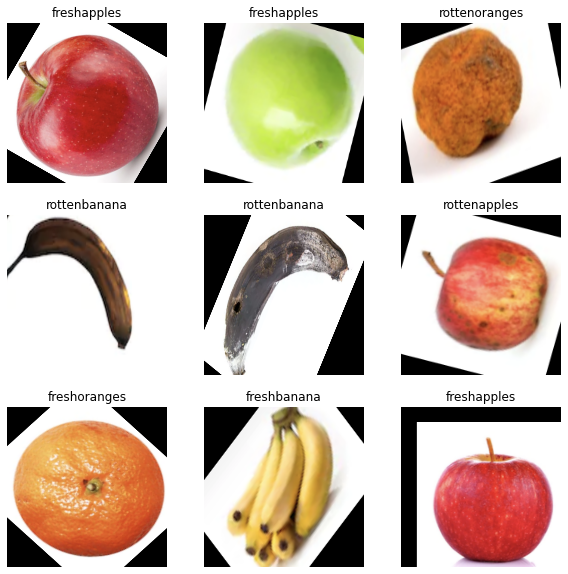

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Creating a test dataset

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
val_batches_num = tf.data.experimental.cardinality(validation_dataset)
test_batches_num = tf.data.experimental.cardinality(test_dataset)
print('Number of validation batches: %d' % val_batches_num)
print('Number of test batches: %d' % test_batches_num)

Number of validation batches: 68
Number of test batches: 17


### Configuring the dataset for performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Rescaling pixel values

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Building the model

I've used Google MobileNet V2 as a base model for this problem. Here I'm importing the model without the classification layers:

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Freezing the convolutional base before appling the transfer learning:

In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Converting the features from the convolutional layers to a vector. As I'm using 32-sized mini-batches for training, I get 32 vectors:

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Adding a custom classification layer:

In [ ]:
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


Putting it all together: 

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compling the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

68/68 [==============================] - 753s 11s/step - loss: 1.8140 - accuracy: 0.1506


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.82
initial accuracy: 0.14


## Training the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/20
341/341 [==============================] - 2894s 8s/step - loss: 1.6223 - accuracy: 0.4501 - val_loss: 1.2259 - val_accuracy: 0.9248
Epoch 2/20
341/341 [==============================] - 312s 916ms/step - loss: 1.2071 - accuracy: 0.9218 - val_loss: 1.1461 - val_accuracy: 0.9531
Epoch 3/20
341/341 [==============================] - 307s 899ms/step - loss: 1.1434 - accuracy: 0.9491 - val_loss: 1.1192 - val_accuracy: 0.9629
Epoch 4/20
341/341 [==============================] - 304s 892ms/step - loss: 1.1210 - accuracy: 0.9594 - val_loss: 1.1055 - val_accuracy: 0.9666
Epoch 5/20
341/341 [==============================] - 308s 904ms/step - loss: 1.1051 - accuracy: 0.9689 - val_loss: 1.0974 - val_accuracy: 0.9721
Epoch 6/20
341/341 [==============================] - 305s 896ms/step - loss: 1.0986 - accuracy: 0.9700 - val_loss: 1.0909 - val_accuracy: 0.9754
Epoch 7/20
341/341 [==============================] - 306s 898ms/step - loss: 1.0912 - accuracy: 0.9753 - val_loss: 1.0836 - v

## Plotting the learning curves

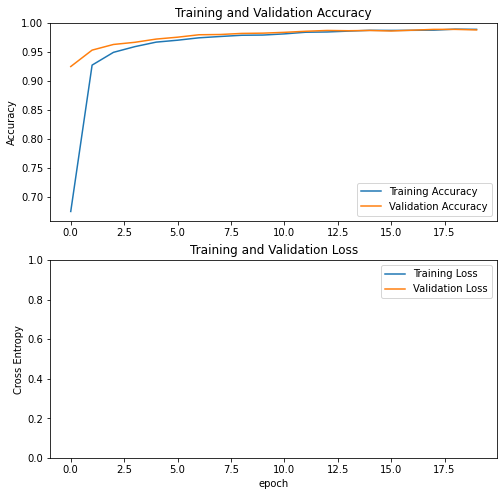

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('fruit_classifier_v2_dropout.h5')

## Checking the final accuracy:

In [ ]:
loss_final, accuracy_final = model.evaluate(test_dataset)

17/17 [==============================] - 343s 20s/step - loss: 1.0602 - accuracy: 0.9926


In [ ]:
print("Final loss: {:.2f}".format(loss_final))
print("Final accuracy: {:.2f}".format(accuracy_final))

Final loss: 1.06
Final accuracy: 0.99
